# Step 1: Data Collection and Pre-processing

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import networkx as nx
from mlxtend.preprocessing import TransactionEncoder
from mlxtend.frequent_patterns import fpgrowth, association_rules

**1.1 Data Loading**

In [ ]:
# Load the dataset
file_path = '/content/MalaysiaUniversityEnrollment20222023.csv'
df = pd.read_csv(file_path)
# Show basic info and first few rows
df

,University,Year,Category,Degree Type,Gender,Value
0,UM,2023,Intake,Postgraduate Diploma,Male,90
1,UM,2022,Intake,Postgraduate Diploma,Male,108
2,UKM,2023,Intake,Postgraduate Diploma,Male,893
3,UKM,2022,Intake,Postgraduate Diploma,Male,397
4,UUM,2023,Intake,Postgraduate Diploma,Male,52
...,...,...,...,...,...,...
1939,UIAM,2022,Output,Others,Total,0
1940,UiTM,2023,Output,Others,Total,0
1941,UiTM,2022,Output,Others,Total,0
1942,UMK,2023,Output,Others,Total,0


**1.2 Clean the Data**

In [ ]:
# Check for missing values before dropping them
missing_values = df.isnull().sum()
print("Missing values in each column:\n", missing_values)

Missing values in each column:
 University     0
Year           0
Category       0
Degree Type    0
Gender         0
Value          0
dtype: int64


In [ ]:
# Drop duplicates and missing values
df.drop_duplicates(inplace=True)
df.dropna(inplace=True)

In [ ]:
# Check for categorical data (potentially suitable for transactions)
print(df.select_dtypes(include='object').nunique())

University     20
Category        3
Degree Type     8
Gender          3
dtype: int64


**1.3 Transform into Transaction Format**

In [ ]:
# Choose features to include in each "transaction"
df['Transaction'] = df[['University', 'Year', 'Category', 'Degree Type', 'Gender']].astype(str).agg(', '.join, axis=1)

# Create list of transactions based on 'Value'
expanded_transactions = []
for _, row in df.iterrows():
    items = row['Transaction'].split(', ')
    count = int(row['Value'])
    expanded_transactions.extend([items] * count)

print(f"\nTotal transactions generated: {len(expanded_transactions)}")


Total transactions generated: 3728320


In [ ]:
# Check for minimum 1500 transactions
if len(expanded_transactions) > 1500:
    print("Dataset meets the minimum transaction requirement (1500).")

Dataset meets the minimum transaction requirement (1500).


**1.4 One-Hot Encode Transactions**

In [ ]:
# Transform into binary matrix
te = TransactionEncoder()
te_ary = te.fit_transform(expanded_transactions)
df_encoded = pd.DataFrame(te_ary, columns=te.columns_)

# Step 2: Exploratory Data Analysis

**2.1 Visualize Frequent Items**

In [ ]:
# Explore item frequency
item_counts = df_encoded.sum().sort_values(ascending=False)

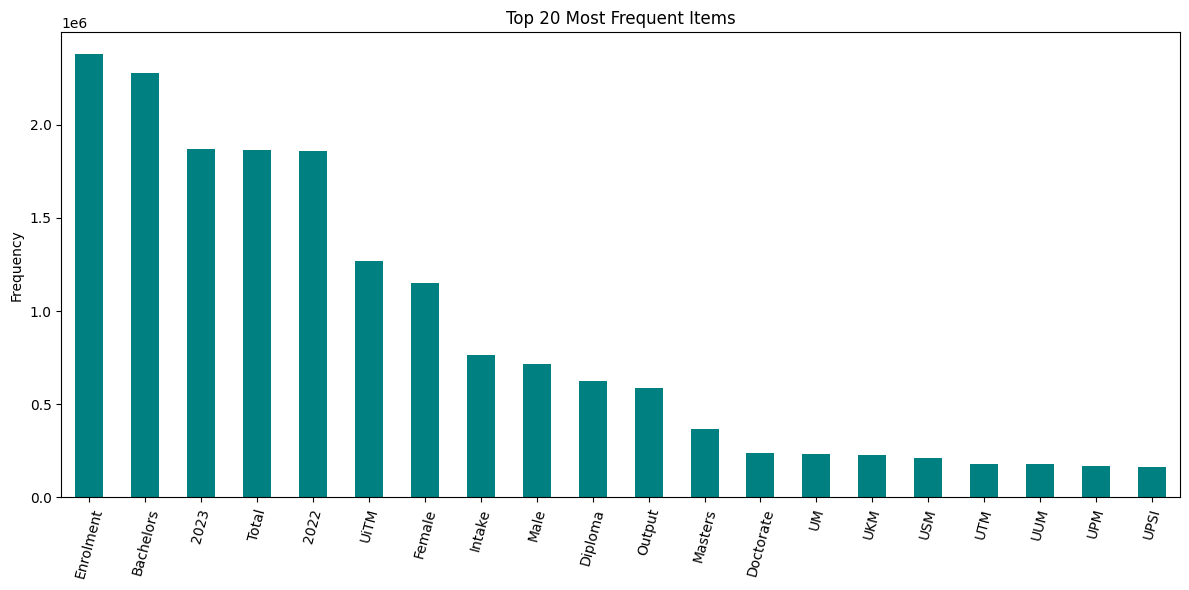

In [ ]:
# Visualize top 20 items
plt.figure(figsize=(12, 6))
item_counts.head(20).plot(kind='bar', color='teal')
plt.title("Top 20 Most Frequent Items")
plt.ylabel("Frequency")
plt.xticks(rotation=75)
plt.tight_layout()
plt.show()

# Step 3: Apply Association Rule Mining Algorithm using FP-Growth

In [ ]:
#  Generate frequent itemsets using FP-Growth
frequent_itemsets = fpgrowth(df_encoded, min_support=0.05, use_colnames=True)

In [ ]:
print("\nFrequent Itemsets Found:")
print(frequent_itemsets.head())


Frequent Itemsets Found:
    support  itemsets
0  0.501618    (2023)
1  0.204888  (Intake)
2  0.191434    (Male)
3  0.062399      (UM)
4  0.498382    (2022)


**3.2 Generate Association Rules**

In [ ]:
# Generate association rules
rules = association_rules(frequent_itemsets, metric="confidence", min_threshold=0.5)

# Sort rules by lift
rules_sorted = rules.sort_values(by="lift", ascending=False)


In [ ]:
# Show top 10 rules
print(rules[['antecedents', 'consequents', 'support', 'confidence', 'lift']].head(10))

           antecedents  consequents   support  confidence      lift
0               (2023)  (Enrolment)  0.318160    0.634267  0.994704
1               (2023)  (Bachelors)  0.306172    0.610369  0.998633
2          (Bachelors)       (2023)  0.306172    0.500932  0.998633
3    (Enrolment, 2023)  (Bachelors)  0.201648    0.633794  1.036958
4    (2023, Bachelors)  (Enrolment)  0.201648    0.658609  1.032879
5             (Intake)       (2023)  0.103547    0.505386  1.007511
6             (Intake)      (Total)  0.102444    0.500000  1.000000
7             (Intake)  (Bachelors)  0.109493    0.534406  0.874347
8       (Intake, 2023)  (Bachelors)  0.055336    0.534402  0.874341
9  (Intake, Bachelors)       (2023)  0.055336    0.505382  1.007504


**Scatter Plot**

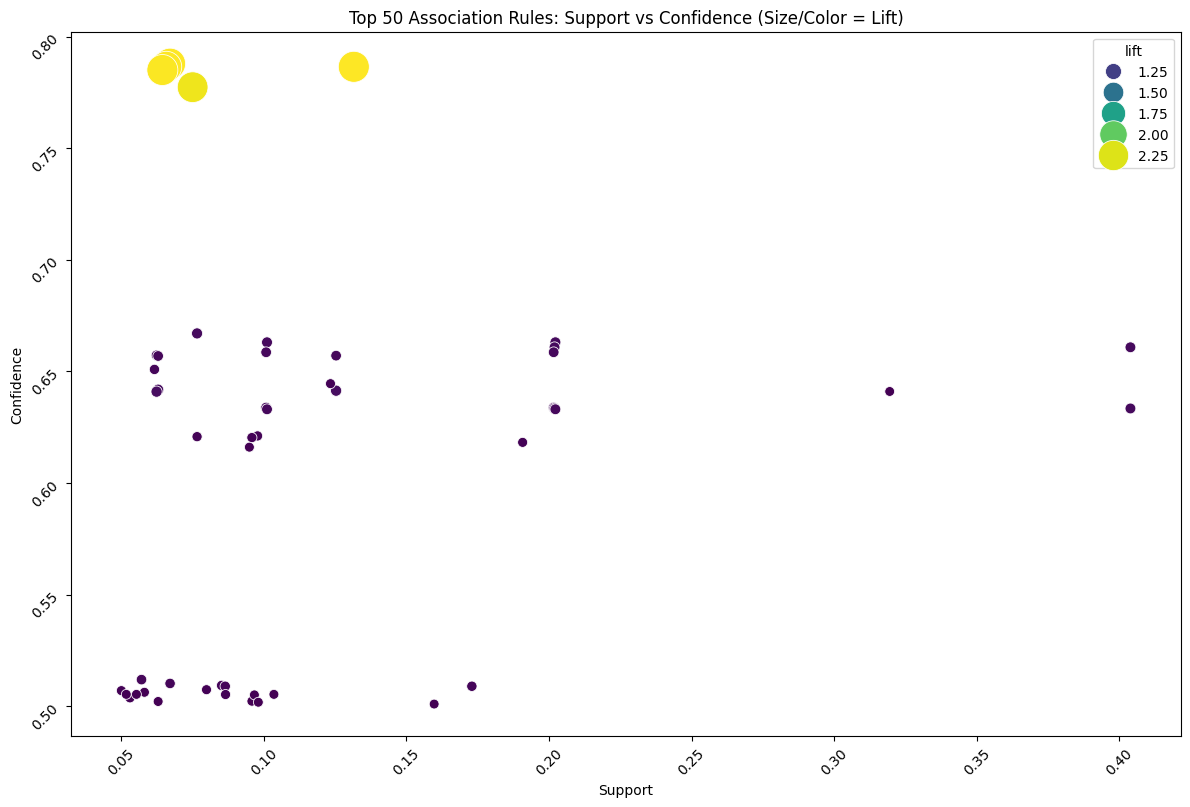

In [ ]:
# Visualizing the top 50 association rules using a scatter plot.
top_rules = rules_sorted.head(50)

plt.figure(figsize=(12, 8))
sns.scatterplot(
    data=top_rules,
    x="support",
    y="confidence",
    size="lift",
    hue="lift",
    palette="viridis",  # Color map to make it visually appealing
    sizes=(50, 500),    # Adjust size range for better visibility
    legend="brief"
)
plt.title("Top 50 Association Rules: Support vs Confidence (Size/Color = Lift)")
plt.xlabel("Support")
plt.ylabel("Confidence")
plt.tight_layout()

# Adjusting label rotation for better readability
plt.xticks(rotation=45)
plt.yticks(rotation=45)
plt.show()

**Network Graph**

<ipython-input-16-77e76da47baf>:22: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


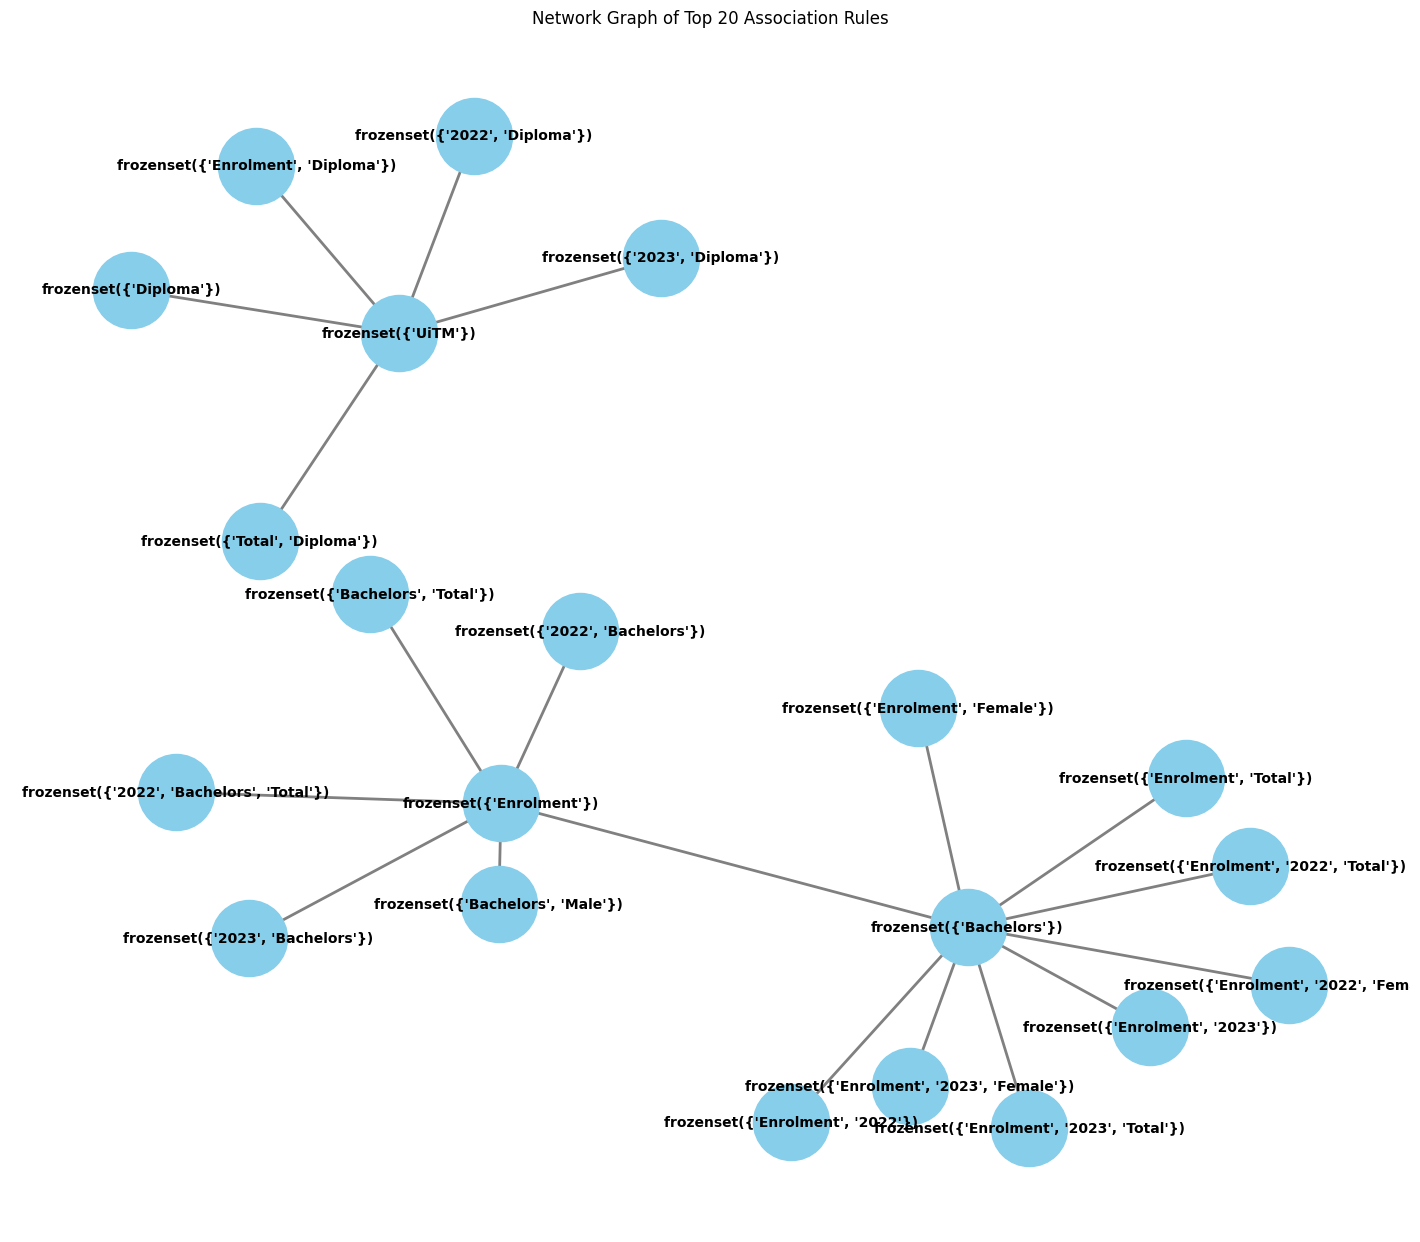

In [ ]:
# Network Graph (Top 20 Rules by Lift)
top_20_rules = rules_sorted.head(20)

G = nx.Graph()

# Add nodes and edges from the top 20 association rules
for _, rule in top_20_rules.iterrows():
    antecedents = str(rule['antecedents'])
    consequents = str(rule['consequents'])
    G.add_edge(antecedents, consequents)

# Draw network graph for the top 20 rules
plt.figure(figsize=(14, 12))

# Use a spring layout for better spacing between nodes
pos = nx.spring_layout(G, k=0.6, seed=42)  # Increase k for more spread

# Draw the graph with simple settings
nx.draw(G, pos, with_labels=True, node_size=3000, node_color="skyblue", font_size=10, font_weight="bold", edge_color="gray", width=2)

plt.title("Network Graph of Top 20 Association Rules")
plt.tight_layout()
plt.show()


In [ ]:
# Display top association rules
print(rules_sorted[['antecedents', 'consequents', 'support', 'confidence', 'lift']].head(10))

                   antecedents  consequents   support  confidence      lift
121            (2022, Diploma)       (UiTM)  0.067135    0.787845  2.318587
123           (Total, Diploma)       (UiTM)  0.065784    0.786460  2.314510
117                  (Diploma)       (UiTM)  0.131568    0.786460  2.314510
120            (2023, Diploma)       (UiTM)  0.064433    0.785022  2.310277
125       (Enrolment, Diploma)       (UiTM)  0.075053    0.777330  2.287640
86   (Enrolment, 2022, Female)  (Bachelors)  0.062951    0.641832  1.050110
92         (Enrolment, Female)  (Bachelors)  0.125353    0.641400  1.049403
80   (Enrolment, 2023, Female)  (Bachelors)  0.062402    0.640965  1.048691
26           (Bachelors, Male)  (Enrolment)  0.076599    0.667047  1.046112
42           (2022, Bachelors)  (Enrolment)  0.202255    0.663060  1.039859


# Step 4: Evaluate and Interpret the Rules

In [ ]:
# Evaluation: Show key metrics for top rules
top_rules_eval = rules_sorted[['antecedents', 'consequents', 'support', 'confidence', 'lift']]
print("\nEvaluation Metrics for Top 10 Rules:")
print(top_rules_eval)


Evaluation Metrics for Top 10 Rules:
              antecedents  consequents   support  confidence      lift
121       (2022, Diploma)       (UiTM)  0.067135    0.787845  2.318587
123      (Total, Diploma)       (UiTM)  0.065784    0.786460  2.314510
117             (Diploma)       (UiTM)  0.131568    0.786460  2.314510
120       (2023, Diploma)       (UiTM)  0.064433    0.785022  2.310277
125  (Enrolment, Diploma)       (UiTM)  0.075053    0.777330  2.287640
..                    ...          ...       ...         ...       ...
91         (Female, UiTM)  (Bachelors)  0.057526    0.515675  0.843703
49           (2023, UiTM)  (Bachelors)  0.084770    0.508109  0.831324
46                 (UiTM)  (Bachelors)  0.171360    0.504303  0.825096
61          (Total, UiTM)  (Bachelors)  0.085680    0.504303  0.825096
68           (2022, UiTM)  (Bachelors)  0.086590    0.500631  0.819089

[129 rows x 5 columns]


**Interpret the Rules**

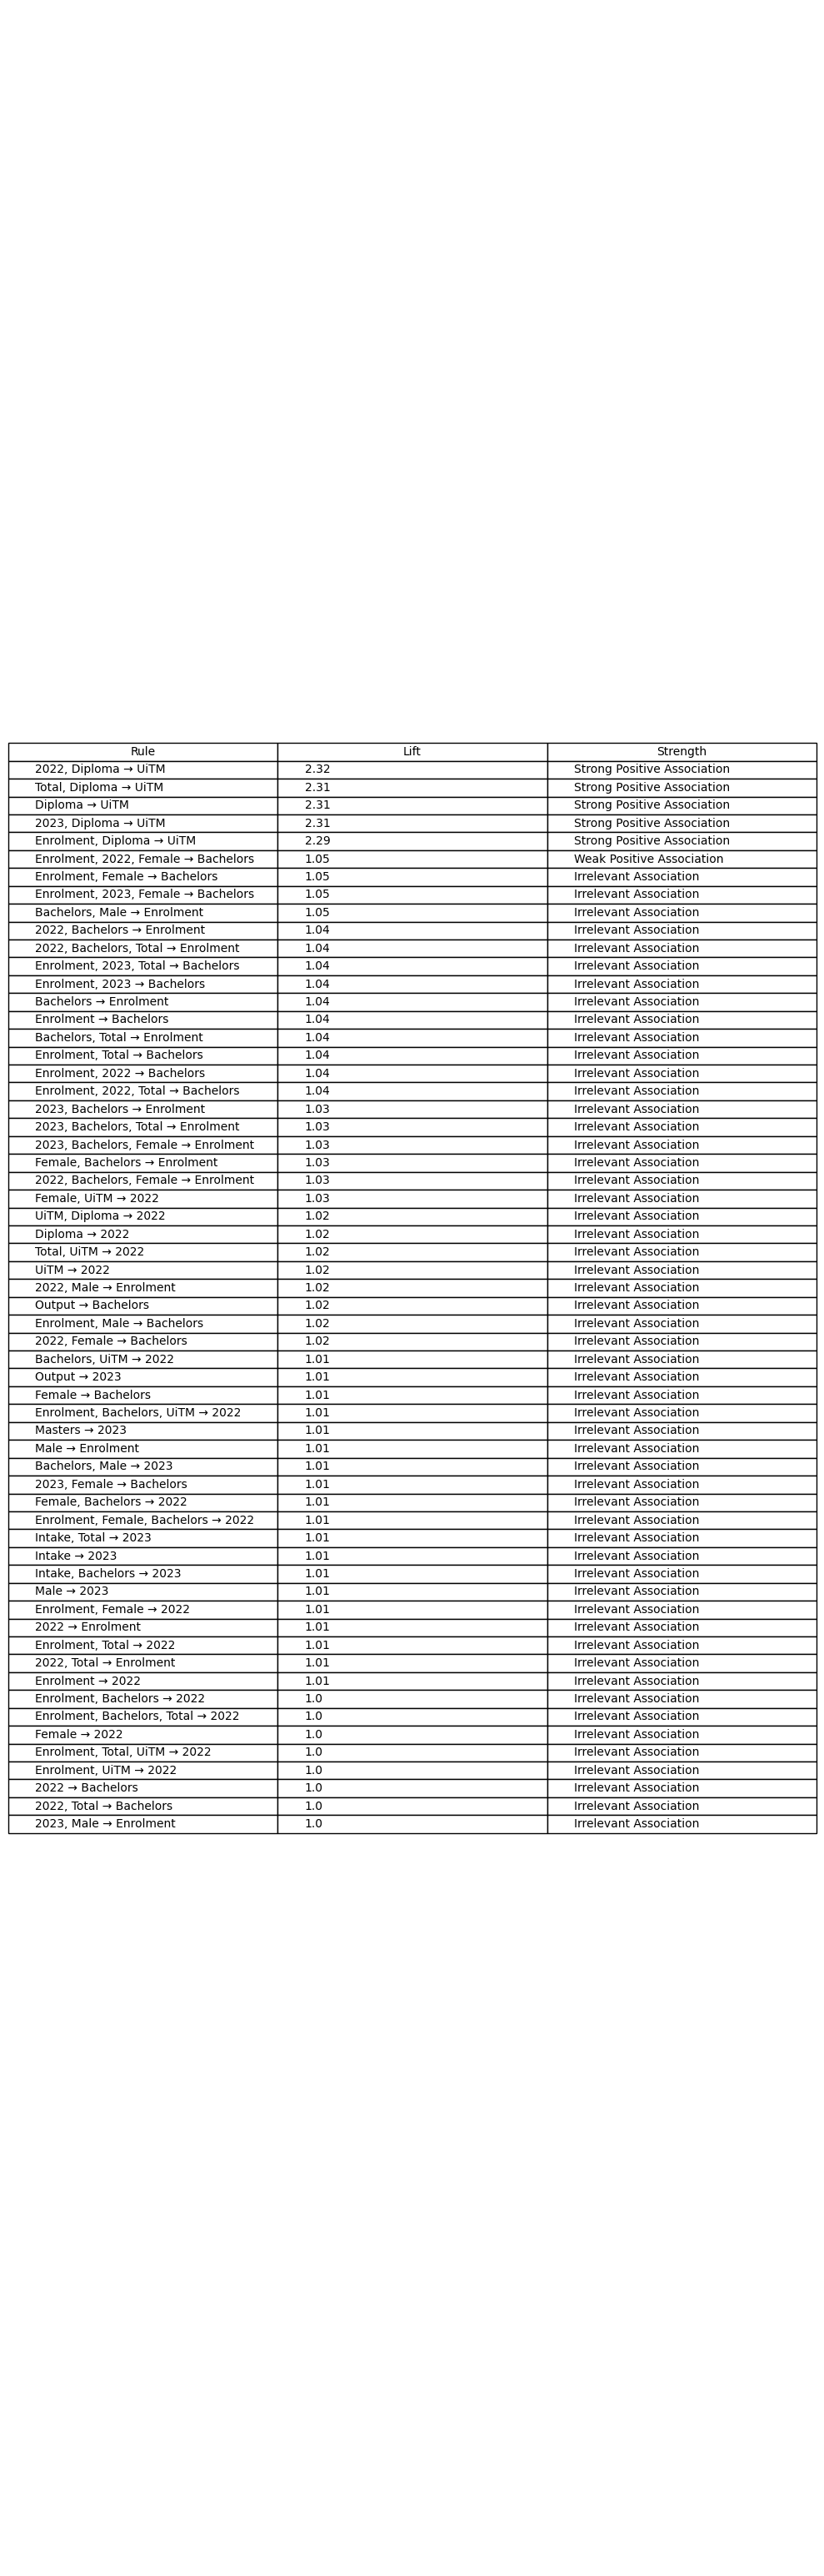

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt

# Collect filtered rule data into a list
rule_data = []

for index, row in top_rules_eval.iterrows():
    lift = row['lift']

    if lift <= 1.00:
        continue

    rule = f"{', '.join(list(row['antecedents']))} → {', '.join(list(row['consequents']))}"

    if lift > 1.5:
        strength = "Strong Positive Association"
    elif lift > 1.2:
        strength = "Moderate Positive Association"
    elif 1.05 < lift <= 1.2:
        strength = "Weak Positive Association"
    else:
        strength = "Irrelevant Association"

    rule_data.append([rule, round(lift, 2), strength])

# Create a DataFrame
df = pd.DataFrame(rule_data, columns=["Rule", "Lift", "Strength"])

# Display as image in Colab
fig, ax = plt.subplots(figsize=(10, len(df) * 0.5 + 1))
ax.axis('off')
table = ax.table(cellText=df.values, colLabels=df.columns, cellLoc='left', loc='center')
table.auto_set_font_size(False)
table.set_fontsize(10)
plt.tight_layout()
plt.show()


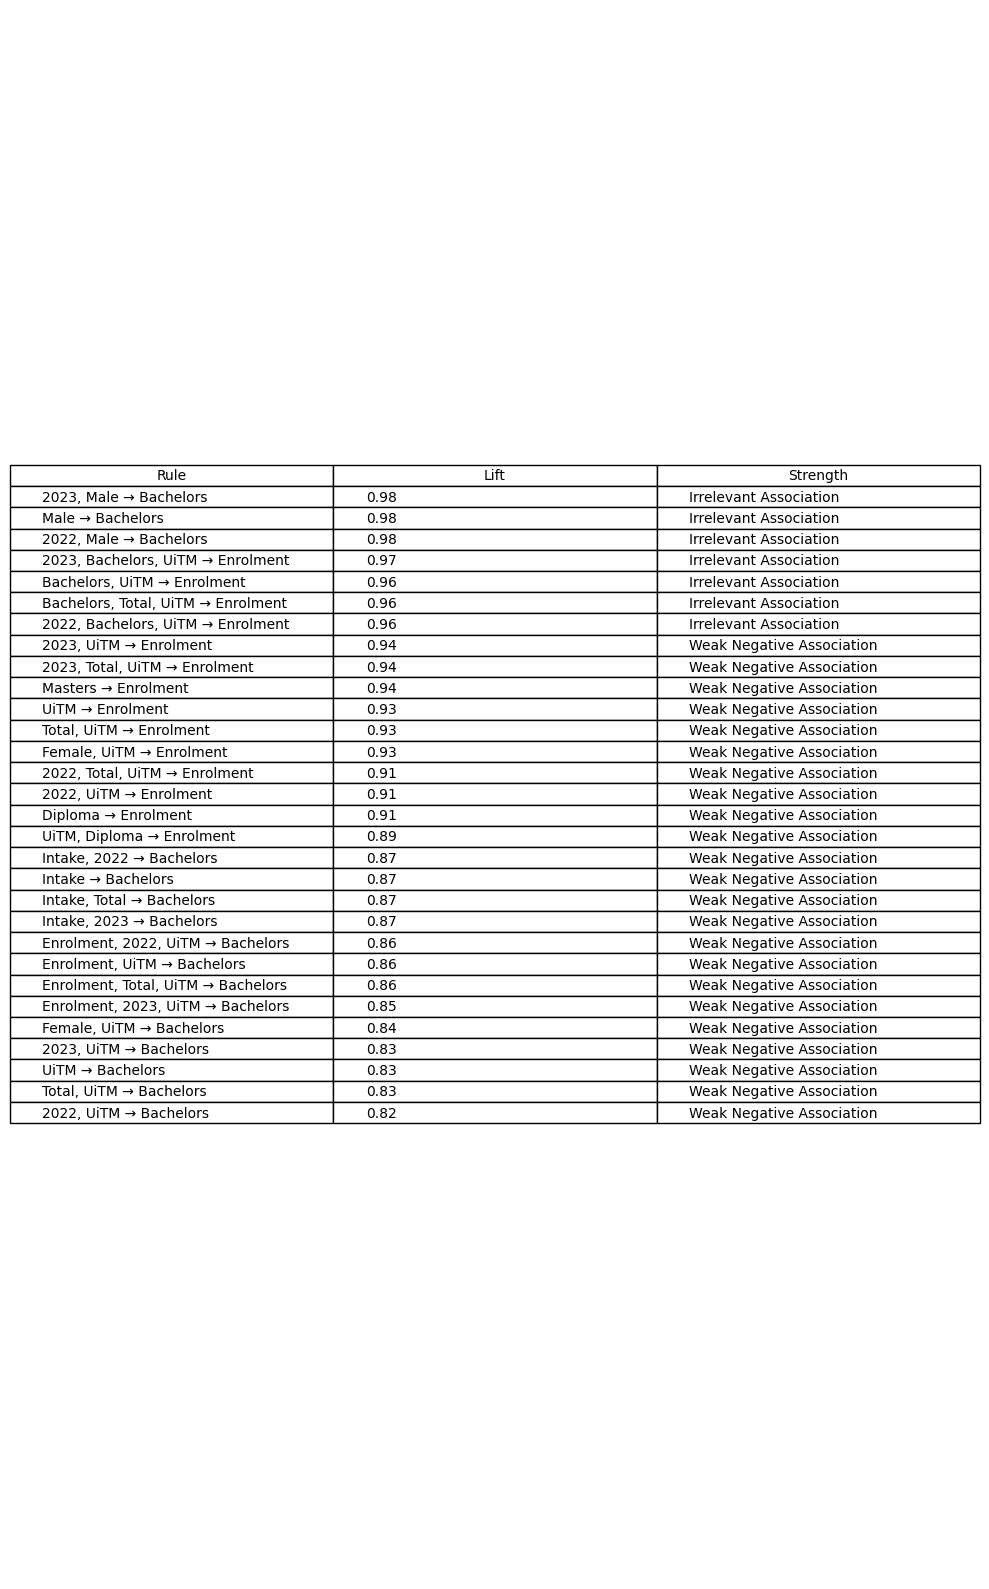


Lowest Lift Rule : 2022, UiTM → Bachelors | Lift: 0.82


In [ ]:
import pandas as pd
import matplotlib.pyplot as plt

# Collect filtered rule data into a list
neg_rule_data = []
min_lift = float('inf')
min_rule = ""

for index, row in top_rules_eval.iterrows():
    lift = row['lift']
    if lift <= 0.99:
        rule = f"{', '.join(list(row['antecedents']))} → {', '.join(list(row['consequents']))}"
        if lift <= 0.5:
            strength = "Strong Negative Association"
        elif lift < 0.95:
            strength = "Weak Negative Association"
        else:
            strength = "Irrelevant Association"

        neg_rule_data.append([rule, round(lift, 2), strength])

        if lift < min_lift:
            min_lift = lift
            min_rule = rule

# Create DataFrame
df_neg = pd.DataFrame(neg_rule_data, columns=["Rule", "Lift", "Strength"])

# Display as image in Colab
fig, ax = plt.subplots(figsize=(10, len(df_neg) * 0.5 + 1))
ax.axis('off')
table = ax.table(cellText=df_neg.values, colLabels=df_neg.columns, cellLoc='left', loc='center')
table.auto_set_font_size(False)
table.set_fontsize(10)
plt.tight_layout()
plt.show()

# Optional: Print lowest lift rule separately
print(f"\nLowest Lift Rule : {min_rule} | Lift: {min_lift:.2f}")


GROUP MEMBERS:
1. MUHAMMAD AJRUL AMIN BIN MOHD ZAIDI (A194789)
2. MUHAMMAD IZZUL ISLAM BIN FASAL (A200363)
3. VILAASINI A/P KUMAR (A195632)